# Chemical features in protein-ligand complex


In this notebook we explore the chemical features of the A chain of the ER-alpha receptor complexed with 
estradiol. We will search for the following features:

- Hydrophobic areas
- Aromatic rings
- Positive ionizable areas
- Negative ionizable areas
- Hydrogen bond donors
- Hydrogen bond acceptors

In [1]:
import openpharmacophore.pharmacophore.pl_interactions as pli
import mdtraj as mdt
import nglview as nv
import numpy as np
from rdkit import Chem

from view_feats import add_features_to_view, add_sphere_to_view

from collections import defaultdict
from pprint import pprint

## Load protein

We load the protein as an mdtraj trajectory as well as an rdkit molecule. The first let us work easily with the
topology of the protein, while the second allows us to find chemical features in the receptor by matching smarts
patterns to it.

In [2]:
# Load all necessary data
traj = mdt.load("./data/er_alpha_A_chain.pdb")
protein = Chem.MolFromPDBFile("./data/er_alpha_A_chain.pdb")

print(f"Trajectory has {traj.n_atoms} atoms")
print(f"Protein has {protein.GetNumAtoms()} atoms")

Trajectory has 2010 atoms
Protein has 2010 atoms


In [3]:
ligands_ids = pli.find_ligands_in_traj(traj)
lig_id = ligands_ids[0]
print(ligands_ids)

['EST:B']


We can see that the trajecotry contains a single ligand whose id is EST and belongs to the B chain.

# Load ligand

We load the ligand directly from the pdb and from its respective smile. We see that the ligand from the pdb
does not have correct bond orders.

In [4]:
ligand_incorrect = Chem.MolFromPDBFile("./data/estradiol.pdb")
ligand_correct = Chem.MolFromSmiles("C[C@]12CC[C@@H]3c4ccc(cc4CC[C@H]3[C@@H]1CC[C@@H]2O)O")

assert ligand_incorrect.GetNumAtoms() == ligand_correct.GetNumAtoms()
print(f"Ligand has {ligand_correct.GetNumAtoms()} atoms")

Ligand has 20 atoms


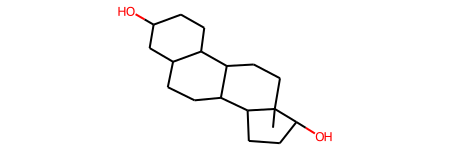

In [5]:
ligand_incorrect

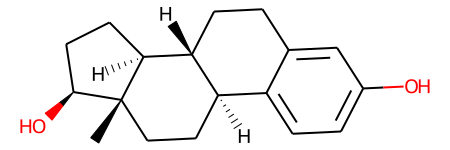

In [6]:
ligand_correct

### Fixing the ligand bond orders

We now must fix the bond orders in the ligand so we can obtain its chemical features

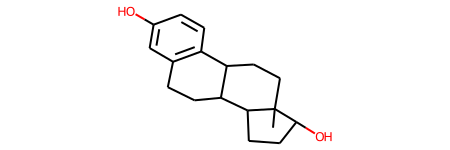

In [7]:
ligand = pli.fix_bond_order_from_smiles(ligand_incorrect, "C[C@]12CC[C@@H]3c4ccc(cc4CC[C@H]3[C@@H]1CC[C@@H]2O)O")
ligand

We must also map the indices of the atoms of the above ligand to the ones in the original trajectory

## Defining the binding site

To define the binding site first we need to find the ligand centroid as well as its maximum extent. The maximum extent of the ligand is defined as the greatest distance from any of its atoms to its centroid.

We define the binding site as all the atoms that are within a distance of BS_DIST + ligand maximum extent from the ligand centroid.

In [8]:
# Cutoff for determination of binding site atoms 
pli.BS_DIST = 0.55  # in nanometers

In [9]:
# Get all necessary ligand data
ligand_indices = pli.get_ligand_atom_indices(traj, lig_id)
lig_centroid = pli.ligand_centroid(traj, lig_id)
lig_extent = pli.ligand_maximum_extent(traj, lig_id)

print(f"Ligand indices len {len(ligand_indices)}")
print(f"Ligand centroid: {lig_centroid}")
print(f"Ligand maximum extent: {lig_extent}")

Ligand indices len 20
Ligand centroid: [10.503935   1.4664251  2.3460498]
Ligand maximum extent: 0.598493754863739


In [10]:
# Get binding site data
bs_indices = pli.get_binding_site_atoms_indices(lig_centroid, lig_extent, traj.xyz[0])
print(f"Bs indices shape {bs_indices.shape}")

Bs indices shape (294,)


In [11]:
view = nv.show_mdtraj(traj)
add_sphere_to_view(view, 
                   lig_centroid * 10, 
                   (lig_extent + pli.BS_DIST) * 10, # multiply by 10 to convert to angstroms
                   "#B03A2E", 
                   "sphere")
view.representations = [
     {"type": "ball+stick", 
      "params": {
          "sele": "protein",
          "color": "residueindex"
      }},
    {"type": "ball+stick", 
     "params": {
         "sele": "( not polymer or hetero ) and not ( water or ion )"
    }}
]
view

NGLWidget()

## Chemical features for the ligand

We obtain the chemical features of the ligand. We use the rdkit molecule to obtain its features, however we must use the coordinates
from the trajectory as well as the indices

In [12]:
indices_mapper = dict(zip(list(range(ligand.GetNumAtoms())), ligand_indices))
ligand_features_rd = pli.chemical_features(ligand, pli.smarts_feat_def)
# Map rdkit ligand indices to mdtraj's
ligand_features = pli.map_ligand_features_indices(ligand_features_rd, indices_mapper)

In [13]:
ligand_feats_center = pli.features_centroid(ligand_features, traj.xyz)

In [14]:
ligand_traj = traj.atom_slice(ligand_indices)
ligand_view = nv.show_mdtraj(ligand_traj)
add_features_to_view(ligand_view, ligand_feats_center)
ligand_view

NGLWidget()

## Binding site chemical features

Now we obtain the chemical features of the binding site atoms of the protein.

In [15]:
bs_feats = pli.chemical_features(protein, pli.smarts_feat_def, bs_indices)
bs_feats_center = pli.features_centroid(bs_feats, traj.xyz)

## Visualize all features

Now we visualize the chemical features

In [16]:
# Trajectory for visualization purposes only
bs_site_traj = traj.atom_slice(np.concatenate((bs_indices, np.array(ligand_indices))))

In [17]:
feats_view = nv.show_mdtraj(bs_site_traj)
add_features_to_view(feats_view, ligand_feats_center)
add_features_to_view(feats_view, bs_feats_center)
feats_view.representations = [
     {"type": "ball+stick", 
      "params": {
          "sele": "protein",
      }},
    {"type": "ball+stick", 
     "params": {
         "sele": "( not polymer or hetero ) and not ( water or ion )",
         "color": "blue",
    }}
]
feats_view

NGLWidget()